# Practice Exam 2021

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# XOR

In [28]:
X = torch.tensor([[0,0], [0, 1], [1,0], [1,1]], dtype=torch.float32)
X = torch.cat((torch.ones(X.shape[0], 1), X), 1)

y = torch.tensor([0, 1, 1, 0], dtype=torch.float32).view(-1, 1)


In [58]:
# create neural network with 1 hidden layer with 2 neurons and no bias
model = nn.Sequential(nn.Linear(3, 2, bias=False), nn.ReLU(), nn.Linear(2, 1, bias=False), nn.Sigmoid())
# use full batch gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.2)
loss_fn = nn.BCELoss()
# train the model
for epoch in range(2000):
    y_pred = model(X.float())

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [59]:
print(model(X))

tensor([[0.0029],
        [0.9983],
        [0.5000],
        [0.0021]], grad_fn=<SigmoidBackward0>)


In [60]:
with torch.no_grad():
    y_pred = model(X)
    predicted_classes = (y_pred >= 0.5).float()
    accuracy = torch.mean((predicted_classes == y).float())
    print(f"Predicted classes: {predicted_classes.numpy()}")
    print(f"Accuracy: {accuracy.item()}")

Predicted classes: [[0.]
 [1.]
 [1.]
 [0.]]
Accuracy: 1.0


In [61]:
# print number of weights
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-9.0219e-05, -3.6324e+00,  3.6325e+00],
                      [ 1.8587e+00, -1.9016e+00,  2.0089e+00]])),
             ('2.weight', tensor([[ 5.1048, -3.1436]]))])

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_72146/2847015022.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_pred >= 0.5).astype(np.int)


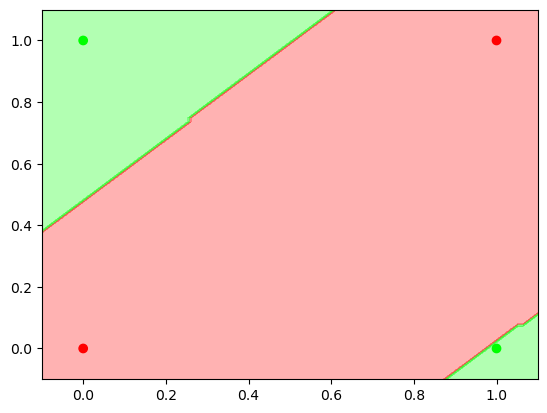

In [62]:
def plot_decision_boundary_bias(X, y, model):
    """ Binary Classification """
    cmap = ListedColormap(["#FF0000", "#00FF00"])
    x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    x2_min, x2_max = X[:, 2].min() - 0.1, X[:, 2].max() + 0.1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    X_grid = np.c_[np.ones(xx1.ravel().shape[0]), xx1.ravel(), xx2.ravel()]
    y_pred = model(torch.tensor(X_grid, dtype=torch.float32)).detach().numpy()
    y_pred = (y_pred >= 0.5).astype(np.int)
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 1], X[:, 2], c=y, cmap=cmap)
    plt.show()

plot_decision_boundary_bias(X.numpy(), y.numpy(), model)

# Decision Tree

In [63]:
X = np.array([[1,2], [2,1], [3,3], [4,3], [5,2], [6,1], [6,3]])
y = np.array(['B', 'A', 'B', 'C', 'A', 'C', 'B'])
y_encoded = np.zeros(len(y), dtype=int)
y_encoded[y == 'A'] = 1
y_encoded[y == 'B'] = 2
y_encoded[y == 'C'] = 3
y = y_encoded


In [64]:
def calculate_node_proportions(class_counts):
    """ 
    Calculates the proportion of samples in each node 
    relative to the total number of samples.
    """
    
    node1 = np.sum(class_counts['node1'])
    node2 = np.sum(class_counts['node2'])
    n = node1 + node2
    return node1 / n, node2 / n

def misclassification_error(class_counts, y):
    """ 
    Calculate misclassification error for the split.
    """
    node1 = class_counts['node1']
    node2 = class_counts['node2']
    
    # calculate misclassification error per node
    error1 = 1 - np.max(node1) / np.sum(node1)
    error2 = 1 - np.max(node2) / np.sum(node2)

    error =  (error1 +  error2) / 2

    return error

def gini_impurity_error(class_counts, y):
    """ 
    Calculate gini impurity error for the split.
    """
    node1 = class_counts['node1']
    node2 = class_counts['node2']
    
    # calculate gini impurity per node
    gini1 = 1 - np.sum((node1 / np.sum(node1)) ** 2)
    gini2 = 1 - np.sum((node2 / np.sum(node2)) ** 2)

    prop1, prop2 = calculate_node_proportions(class_counts)
    
    # calculate weighted gini impurity
    gini =  prop1 * gini1 + prop2 * gini2

    return gini

def cross_entropy_error(class_counts, y):
    """ 
    Calculate cross entropy error for the split.
    """
    node1 = class_counts['node1']
    node2 = class_counts['node2']
    
    node1 = node1[node1 != 0]
    node2 = node2[node2 != 0]
    
    # calculate cross entropy for present classes in each node
    cross_entropy1 = - np.sum(node1 / np.sum(node1) * np.log(node1 / np.sum(node1)))
    cross_entropy2 = - np.sum(node2 / np.sum(node2) * np.log(node2 / np.sum(node2)))

    prop1, prop2 = calculate_node_proportions(class_counts)
    
    # calculate weighted cross entropy
    cross_entropy =  prop1 * cross_entropy1 + prop2 * cross_entropy2

    return cross_entropy

In [65]:
def decision_stump_classifier(X, y):
    """ 
    Decision tree of depth 1 that finds the best split for the data.
    Finds splits and make prediction for the most present class in the split.
    """
    # dict that stores number of classes in each node
    
    best_accuracy = 0
    class_counts = {}
    
    for feature in range(X.shape[1]):
        for threshold in np.unique(X[:, feature]):
            # avoid empty splits
            if np.sum(X[:, feature] <= threshold) == 0 or np.sum(X[:, feature] > threshold) == 0:
                continue
            idx1 = X[:, feature] > threshold
            idx2 = ~idx1
            y_node1 = y[idx1]
            y_node2 = y[idx2]

            y_pred1 = np.bincount(y_node1).argmax()
            y_pred2 = np.bincount(y_node2).argmax()

            accuracy = np.sum(y_node1 == y_pred1) + np.sum(y_node2 == y_pred2)

            if accuracy >= best_accuracy:
                best_threshold = threshold
                best_feature = feature
                # get classwise proportions in each node
                class_counts['node1'] = np.bincount(y_node1)
                class_counts['node2'] = np.bincount(y_node2)

    return best_feature, best_threshold, class_counts
    


In [66]:
feature, thresh, counts = decision_stump_classifier(X, y)
print(f"Best feature: {feature}, threshold: {thresh}")
print(f"split value = {thresh}")
print(f"node1: {counts['node1']}")
print(f"node2: {counts['node2']}")

Best feature: 1, threshold: 2
split value = 2
node1: [0 0 2 1]
node2: [0 2 1 1]


In [67]:
misclassification_error(counts, y), gini_impurity_error(counts, y), cross_entropy_error(counts, y)

(0.4166666666666667, 0.5476190476190476, 0.8669179411777299)

In [68]:
def plot_decision_stump_boundary(X, y, feature, thresh):
    """ plot decision boundary for decision stump """
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = np.zeros(len(X_grid))
    y_pred[X_grid[:, feature] < thresh] = 1
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    plt.show()


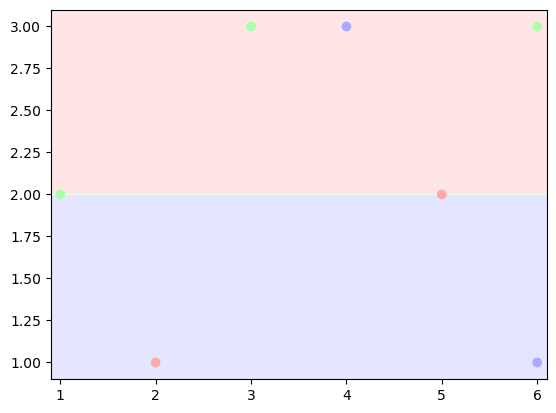

In [69]:
plot_decision_stump_boundary(X, y, feature, thresh)

In [70]:
def plot_decision_boundary(X, y, model):
    """ plot decision boundary for decision tree """
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(X_grid)
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    plt.show()

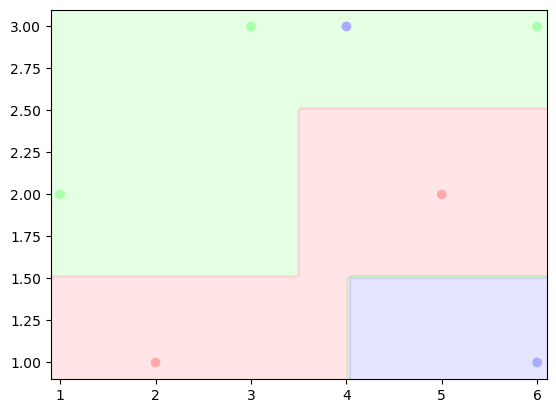

In [71]:
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X, y)
plot_decision_boundary(X, y, tree_model)

In [72]:
# get splits from tree
splits = tree_model.tree_.threshold
features = tree_model.tree_.feature
predictions = tree_model.tree_.value
# dicts with feature and splits pairs
splits_dict = dict(zip(features, splits))
splits_dict

{1: 2.5, 0: 3.5, -2: -2.0}

(22, 2)


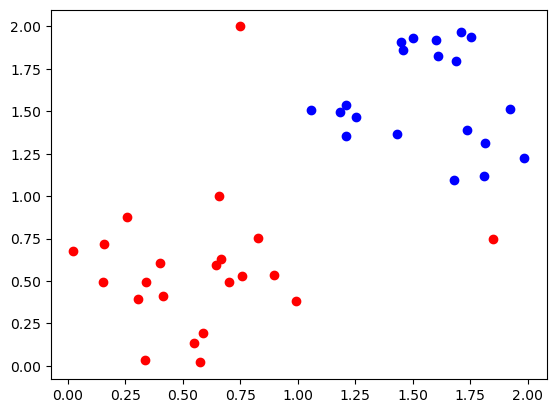

In [73]:
x1 = np.random.rand(20,2)
x2 = np.random.rand(20,2) + 1
x1 = np.concatenate((x1, np.array([[1.85, 0.75]])))
x1 = np.concatenate((x1, np.array([[0.75, 2]])))

X = np.concatenate((x1, x2))
y = np.array([1 if x in x1 else -1 for x in X])

print(x1.shape)

plt.scatter(x=x1[:,0], y=x1[:,1], label='x1', color='r')
plt.scatter(x=x2[:,0], y=x2[:,1], label='x2', color='b')

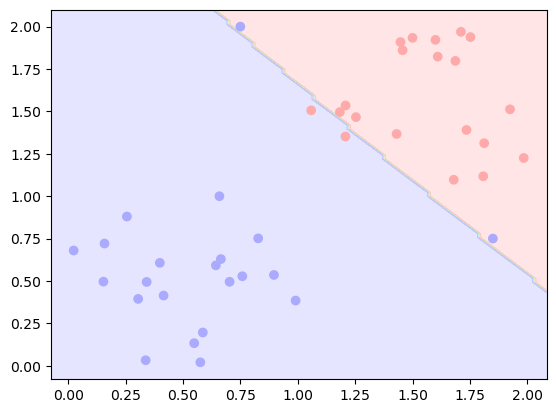

In [74]:
svm = SVC(C = 0.001, kernel='poly')
svm.fit(X, y)
y_pred = svm.predict(X)

np.mean(y_pred == y)

plot_decision_boundary(X, y, svm)

In [75]:
def neuron_linear_equation(x1, y1, x2, y2):
    """ create m and b for line equation y = mx + b """
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    return m, b



N1 : -1.000 + x1 * 0.667 + x2 * 1 = 0
N2 : 8.000 + x1 * -2.433 + x2 * 1 = 0


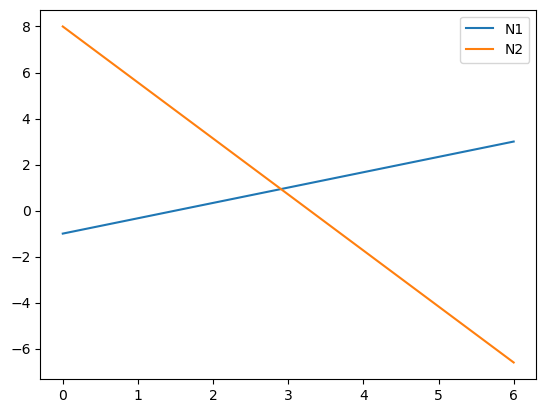

In [79]:
p11 = np.array([3, 1])
p12 = np.array([6, 3])

p21 = np.array([0, 8])
p22 = np.array([3, 0.7])

x = np.linspace(0, 6, 100)

w_11, w_10 = neuron_linear_equation(x1=p11[0], y1=p11[1], x2=p12[0], y2=p12[1])
w_21, w_20 = neuron_linear_equation(x1=p21[0], y1=p21[1], x2=p22[0], y2=p22[1])

x21 = w_11 * x + w_10
x22 = w_21 * x + w_20
print(f'N1 : {w_10:.3f} + x1 * {w_11:.3f} + x2 * {1} = 0')
print(f'N2 : {w_20:.3f} + x1 * {w_21:.3f} + x2 * {1} = 0')

plt.plot(x, x21, label='N1')
plt.plot(x, x22, label='N2')

plt.legend()



In [81]:
# create pytorch neural network class that takes h1 as input and has 1 neuron to output

class Net(nn.Module):
    """2 dimensional input where first layer has
       fixed weights and second layer has trainable weights 
       it has 2 neurons to 1 neuron in the"""
    def __init__(self, W1, b1):
        super().__init__()
        # create w1 with fixed n1 and n2 and a bias term to be mulitplied by W2
        self.W1 = W1
        self.b1 = b1
        self.W2 = nn.Parameter(torch.randn(2, dtype=torch.float32), requires_grad=True)
        self.b2 = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    
    def forward(self, x):
        h1 = x @ self.W1 + self.b1
        h1 = self.relu(h1)
        h2 = h1 @ self.W2 + self.b2      
        h2 = self.sigmoid(-h2)
        return h2
    
    def train(self, X, y, epochs, lr):
        optimizer = optim.SGD([self.W2], lr=lr)
        criterion = nn.BCELoss()
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(X)
            loss = criterion(y_pred, y.float())
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, loss: {loss.item():.3f}')
        return self.W2    

In [ ]:
m1, b1 = neuron_linear_equation(x1=3, y1=1, x2=5, y2=3)
m2, b2 = neuron_linear_equation(x1=0, y1=4.5, x2=3, y2=0.5)


w1 = torch.tensor([1, m1], dtype=torch.float32)
w2 = torch.tensor([1, m2], dtype=torch.float32)
bias = torch.tensor([b1, b2], dtype=torch.float32)

W1 = torch.stack([w1, w2], dim=0)
model = Net(W1=W1, b1=bias)
model.train(X, y, epochs=1000, lr=0.1)

pred = model.forward(X)
pred.detach()
pred = torch.where(pred > 0.5, 0, 1)
torch.mean((pred == y).float())

# Practice Exam 2022

In [83]:
# create numpy arrays from this data x : y
# 1 0.15 2 −0.01 3 0.40 4 0.26 5 1.50 6 3.59
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([0.15, -0.01, 0.40, 0.26, 1.50, 3.59])

# add bias
x = np.stack([np.ones_like(x), x], axis=1)

# OLS
w = np.linalg.inv(x.T @ x) @ x.T @ y
# Ridge
w_ridge = np.linalg.inv(x.T @ x + np.eye(w.shape[0])) @ x.T @ y

print(f'OLS: {w}')
print(f'Ridge: {w_ridge}')

OLS: [-1.17733333  0.61685714]
Ridge: [-0.57995074  0.4737931 ]


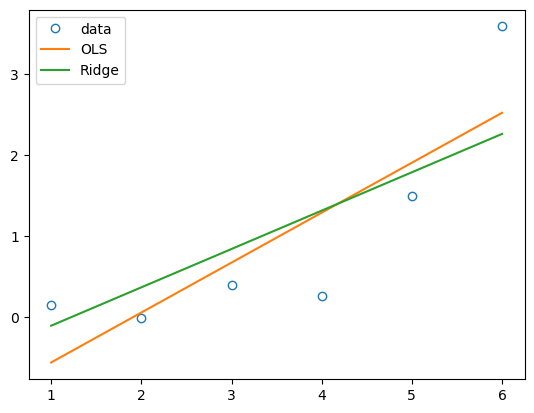

In [84]:
plt.plot(x[:,1], y, 'o', fillstyle='none', label='data')
plt.plot(x[:,1], x @ w, label='OLS')
plt.plot(x[:,1], x @ w_ridge, label='Ridge')

plt.legend()

OLS: 98.82266666666656
Ridge: 10.81862068965517
Partial Ridge: [98.82266667 10.81862069]
Ridge: [54.09985222 10.81862069]


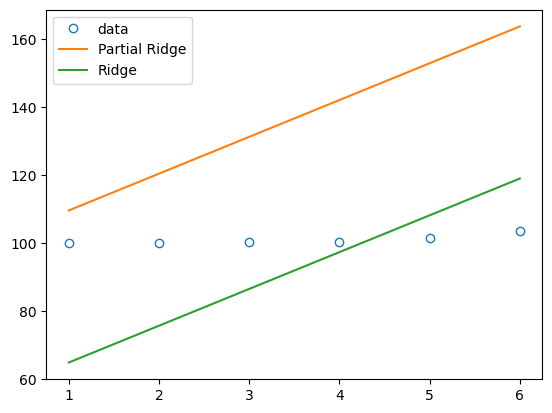

In [85]:
y = np.array([0.15, -0.01, 0.40, 0.26, 1.50, 3.59]) + 100

w1,_ = np.linalg.inv(x.T @ x) @ x.T @ y
_, w2 = np.linalg.inv(x.T @ x + np.eye(w.shape[0])) @ x.T @ y

print(f'OLS: {w1}')
print(f'Ridge: {w2}')
# partial ridge
w_partial_ridge = np.array([w1, w2])
w_ridge = np.linalg.inv(x.T @ x + np.eye(w.shape[0])) @ x.T @ y

print(f'Partial Ridge: {w_partial_ridge}')
print(f'Ridge: {w_ridge}')

plt.plot(x[:,1], y, 'o', fillstyle='none', label='data')
plt.plot(x[:,1], x @ w_partial_ridge, label='Partial Ridge')
plt.plot(x[:,1], x @ w_ridge, label='Ridge')

plt.legend()


In [221]:
x = np.array([[0.0, 0.1], [0.1, 0.0], [0.9, 1.0], [1.0, 0.9]])

c1 = np.array([1,0])
c2 = np.array([0,1])


In [222]:
def k_means(x, c1, c2):
    loss = 1000
    current_loss = np.inf

    epoch = 1
    while loss < current_loss:
        # k means clustering
        current_loss = loss
        # calculate distance from each point to each centroid
        dist_c1 = np.linalg.norm(x - c1, axis=1)
        dist_c2 = np.linalg.norm(x - c2, axis=1)

        # assign each point to the closest centroid
        c1_idx = dist_c1 < dist_c2

        # calculate new centroids
        c1 = np.mean(x[c1_idx], axis=0)
        c2 = np.mean(x[~c1_idx], axis=0)

        # calculate loss
        loss = np.sum(dist_c1[c1_idx]) + np.sum(dist_c2[~c1_idx])
        print(f'Epoch: {epoch}, loss: {loss}')

        epoch += 1
    return c1, c2, c1_idx

c1, c2, c1_idx = k_means(x, c1, c2)


Epoch: 1, loss: 3.6
Epoch: 2, loss: 2.5455844122715714
Epoch: 3, loss: 2.5455844122715714


In [223]:
def plot_k_means(x, c1, c2, c1_idx):
    fig, ax = plt.subplots()

    # plot the data and circle around centroid with max distance in centroid
    # plt.scatter(x[:,0], x[:,1], 'o', fillstyle='none', label='data')
    ax.scatter(c1[0], c1[1], color='r', label='centroid 1')
    ax.scatter(c2[0], c2[1], color='b', label='centroid 2')

    # calculate distance from each point to each centroid
    max_dist_c1 = max(np.linalg.norm(x[c1_idx]- c1, axis=1))
    max_dist_c2 = max(np.linalg.norm(x[~c1_idx]- c2, axis=1))

    # plot circle around centroid with max distance in centroid
    ax.add_patch(plt.Circle(c1, max_dist_c1, fill=False, color='r'))
    ax.add_patch(plt.Circle(c2, max_dist_c2, fill=False, color='b'))

    x1= x[c1_idx]
    x2 = x[~c1_idx]

    ax.scatter(x1[:,0], x1[:,1], color='r', label='cluster 1', marker='x')
    ax.scatter(x2[:,0], x2[:,1], color='b', label='cluster 2', marker='x')

    ax.legend(loc='best')

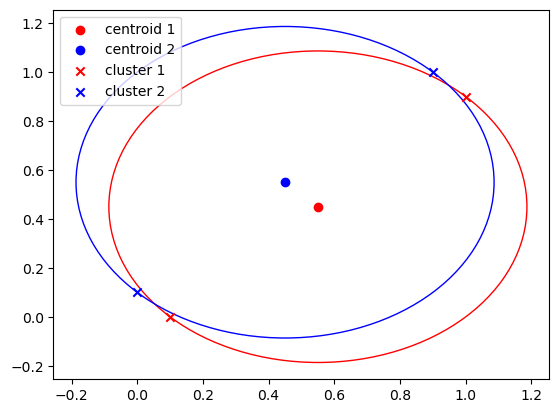

In [224]:
plot_k_means(x, c1, c2, c1_idx)

In [225]:
# Gaussian Mixture Models
class GaussianMixtureModel2D(nn.Module):
    def __init__(self, mu1, mu2, sig1, sig2):
        super().__init__()
        self.mu1 = mu1
        self.mu2 = mu2
        self.sig1 = sig1
        self.sig2 = sig2
        self.alpha = torch.tensor([0.5])

    def gmm_gamma(self, x):
        """ 
        Calculate the probability (responsiblity) of each point in each cluster
        """
        # calculate probability of each point in each cluster
        log_p1 = torch.distributions.multivariate_normal.MultivariateNormal(self.mu1, self.sig1).log_prob(x) 
        log_p2 = torch.distributions.multivariate_normal.MultivariateNormal(self.mu2, self.sig2).log_prob(x) 

        # calculate probability of each point in each cluster
        p1 = torch.exp(log_p1) * self.alpha
        p2 = torch.exp(log_p2) * (1 - self.alpha)
        
        gamma1 = p1 / ( p1 + p2)
        gamma2 = p2 / ( p1 + p2)

        self.alpha = torch.sum(gamma1) / x.shape[0]
        
        return gamma1, gamma2

    def train(self, x, epochs):
        """ 
        Calculate the parameters of a Gaussian mixture model using the EM algorithm
        """

        for _ in range(epochs):
            # E step
            gamma1, gamma2 = self.gmm_gamma(x)
            
            # M step
            self.mu1 = torch.sum(gamma1 * x.T, axis=1) / torch.sum(gamma1)
            self.mu2 = torch.sum(gamma2 * x.T, axis=1) / torch.sum(gamma2)
            
            self.sig1 = (gamma1 * (x - self.mu1).t() @ (x - self.mu1)) / torch.sum(gamma1)
            self.sig2 = (gamma2 * (x - self.mu2).t() @ (x - self.mu2)) / torch.sum(gamma2)

        return self.mu1, self.mu2, self.sig1, self.sig2

In [226]:
x_numpy = np.array([[0.0, 0.1], [0.1, 0.0], [0.9, 1.0], [1.0, 0.9]])

x = torch.tensor(x_numpy, dtype=torch.float32)
x1, x2 = torch.tensor(x_numpy[c1_idx], dtype=torch.float32), torch.tensor(x_numpy[~c1_idx], dtype=torch.float32)

# get intial means of each cluster
mu1,mu2 = torch.tensor(c1), torch.tensor(c2)

# get initial covariance in each cluster
sigma1 = torch.cov(x.T) + torch.eye(2) * 0.1
sigma2 = sigma1

gmm = GaussianMixtureModel2D(mu1, mu2, sigma1, sigma2)
mu1, mu2, sigma1, sigma2 = gmm.train(x=x, epochs=1)

In [227]:
c1_dist = torch.distributions.multivariate_normal.MultivariateNormal(mu1, sigma1)
c2_dist = torch.distributions.multivariate_normal.MultivariateNormal(mu2, sigma2)

# calculate probability of each point in each cluster
p1 = torch.exp(c1_dist.log_prob(x)) * gmm.alpha
p2 = torch.exp(c2_dist.log_prob(x)) * (1 - gmm.alpha)

# calculate probability of each point in each cluster
resp1 = p1 / ( p1 + p2)
resp2 = p2 / ( p1 + p2)

In [228]:
# plot distribution contours of the GMM 
def plot_gmm(x, gmm):
    fig, ax = plt.subplots()

    x1 = np.linspace(0, 1, 100)
    x2 = np.linspace(0, 1, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    zz = np.c_[xx1.ravel(), xx2.ravel()]

    p1 = torch.exp(c1_dist.log_prob(torch.tensor(zz, dtype=torch.float32))) * gmm.alpha
    p2 = torch.exp(c2_dist.log_prob(torch.tensor(zz, dtype=torch.float32))) * (1 - gmm.alpha)

    # plot contours
    ax.contourf(x1, x2, p1.reshape(100,100), cmap='Reds', alpha=0.3)
    ax.contourf(x1, x2, p2.reshape(100,100), cmap='Blues', alpha=0.3)

    # plot data
    ax.scatter(x[:,0], x[:,1], color='k', marker='x')

    # plot cluster 1
    ax.scatter(x[c1_idx][:,0], x[c1_idx][:,1], color='r', marker='x')

    # plot cluster 2
    ax.scatter(x[~c1_idx][:,0], x[~c1_idx][:,1], color='b', marker='x')

    # plot centroid of each cluster
    ax.scatter(mu1[0], mu1[1], color='r', marker='o')
    ax.scatter(mu2[0], mu2[1], color='b', marker='o')

    ax.set_xlim(0-0.01,1+0.01)
    ax.set_ylim(0-0.01,1+0.01);



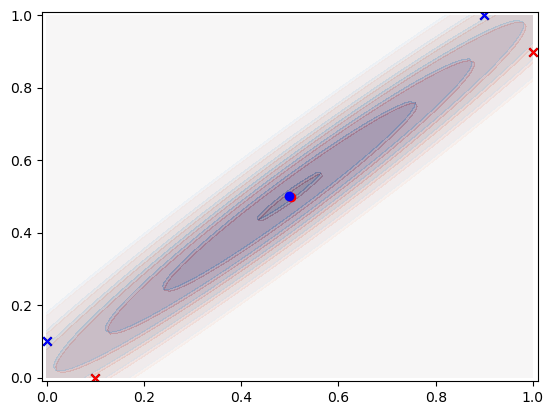

In [229]:
plot_gmm(x, gmm)

In [230]:
# print the parameters of the GMM
print('mu1: ', mu1.numpy())
print('mu2: ', mu2.numpy())
print('sigma1: ', sigma1.numpy())
print('sigma2: ', sigma2.numpy())
print('alpha1: ', gmm.alpha.numpy())
print('alpha2: ', (1 - gmm.alpha).numpy())
print('gamma1: ', resp1.numpy())
print('gamma2: ', resp2.numpy())


mu1:  [0.502342   0.49765792]
mu2:  [0.49765795 0.50234205]
sigma1:  [[0.2049945  0.20000547]
 [0.20000547 0.20499451]]
sigma2:  [[0.2049945  0.20000547]
 [0.20000547 0.20499451]]
alpha1:  0.5
alpha2:  0.5
gamma1:  [0.4765454  0.52345467 0.47654524 0.52345467]
gamma2:  [0.5234546  0.47654536 0.5234548  0.47654533]


In [231]:
z = 1
h = -1/12
dz = lambda x: 8*x**3 + 4*x
for i in range(5):
    z = z + h * dz(z)
    print(f'z{i+1} = {z:.2f}')

z1 = 0.00
z2 = 0.00
z3 = 0.00
z4 = 0.00
z5 = 0.00


In [345]:
class ConvNetOperations(nn.Module):
    """ 
    Class that performs a series of convolutional operations

    Args:
        conv_ops (list): list of tuples (filters, stride, kernel_size, padding)
        channels (int): number of channels in the input

    """
    def __init__(self, conv_ops, channels=3, bias=True):
        super(ConvNetOperations, self).__init__()
        self.conv_ops = conv_ops
        self.bias = bias
        self.conv_layers = nn.ModuleList()
        self.channels = channels
        self.layer_outputs = []
        self._build_model()
    
    def _build_model(self):
     
        for filters, stride, kernel_size, padding in self.conv_ops:
            self.conv_layers.append(nn.Conv2d(in_channels=self.channels, 
                                              out_channels=filters, 
                                              kernel_size=kernel_size, 
                                              stride=stride, 
                                              padding=padding,
                                              bias=self.bias))
            self.channels = filters
        
    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            self.layer_outputs.append(x.shape[1:])
        return x
    
    def get_output_size(self, input_size):
        x = torch.randn(1, *input_size)
        return self.forward(x).shape[1:]
    
    def get_num_params(self):
        return sum([np.prod(p.shape) for p in self.parameters()])
    
    def get_num_params_per_layer(self):
        params = [np.prod(p.shape) for p in self.parameters()]
        return [sum(params[i:i+2]) for i in range(0, len(params), 2)]
    

In [346]:
# tuples are (filters, stride, kernel_size, padding)
conv_ops = [(16, 1, 3, 1), (8, 1, 5, 2), (8, 1, 3, 1)]
input_size = (3, 32, 32)
channels = 3

In [347]:
# create a model
model = ConvNetOperations(conv_ops, channels=channels)

# get output size of the model
output_size = model.get_output_size(input_size)

# get number of parameters in the model
num_params = model.get_num_params()

# get number of parameters in each layer of the model
num_params_per_layer = model.get_num_params_per_layer()


In [348]:

print('output size: ', output_size)
print('number of parameters: ', num_params)
print('number of parameters per layer: ', num_params_per_layer)
print('layer outputs: ', model.layer_outputs)

# convolutions are calculated as follows (for height and width):
# output_size = (input_size - kernel_size + 2 * padding) / stride + 1

# the parameters of each layer are calculated as follows:
# num_params = filters * kernel_size * kernel_size * channels + filters

output size:  torch.Size([8, 32, 32])
number of parameters:  4240
number of parameters per layer:  [448, 3208, 584]
layer outputs:  [torch.Size([16, 32, 32]), torch.Size([8, 32, 32]), torch.Size([8, 32, 32])]


# Exam 2022

In [236]:
def kmeans_1d(x, c1, c2):
    """ do k means algoritm until convergence"""
    loss = 1000
    current_loss = np.inf

    epoch = 1
    while loss < current_loss:
        # k means clustering
        current_loss = loss
        # calculate distance from each point to each centroid
        dist_c1 = np.abs(x - c1)
        dist_c2 = np.abs(x - c2)

        # assign each point to the closest centroid
        c1_idx = dist_c1 < dist_c2

        # calculate new centroids
        c1 = np.mean(x[c1_idx])
        c2 = np.mean(x[~c1_idx])

        # calculate loss
        loss = np.sum(dist_c1[c1_idx]) + np.sum(dist_c2[~c1_idx])
        print(f'Epoch: {epoch}, loss: {loss}')

        epoch += 1
    return c1, c2, c1_idx
    

In [244]:
class GaussianMixtureModel1D(nn.Module):
    def __init__(self, mu1, mu2, sig1, sig2):
        super().__init__()
        self.mu1 = mu1
        self.mu2 = mu2
        self.sig1 = sig1
        self.sig2 = sig2
        self.alpha = torch.tensor([0.5])

    def gmm_gamma(self, x):
        """ 
        Calculate the probability (responsiblity) of each point in each cluster
        """
        # calculate probability of each point in each cluster
        log_p1 = torch.distributions.Normal(loc=self.mu1, scale=self.sig1).log_prob(x)
        log_p2 = torch.distributions.Normal(loc=self.mu2, scale=self.sig2).log_prob(x)

        # calculate probability of each point in each cluster
        p1 = torch.exp(log_p1) * self.alpha
        p2 = torch.exp(log_p2) * (1 - self.alpha)
        
        gamma1 = p1 / ( p1 + p2)
        gamma2 = p2 / ( p1 + p2)

        self.alpha = torch.sum(gamma1) / x.shape[0]
        
        return gamma1, gamma2

    def train(self, x, epochs):
        """ 
        Calculate the parameters of a Gaussian mixture model using the EM algorithm
        """

        for _ in range(epochs):
            # E step
            gamma1, gamma2 = self.gmm_gamma(x)
            
            # M step
            self.mu1 = torch.sum(gamma1 * x, axis=1) / torch.sum(gamma1)
            self.mu2 = torch.sum(gamma2 * x, axis=1) / torch.sum(gamma2)
            
            self.sig1 = (gamma1 * (x - self.mu1).t() @ (x - self.mu1)) / torch.sum(gamma1) * torch.eye(1)
            self.sig2 = (gamma2 * (x - self.mu2).t() @ (x - self.mu2)) / torch.sum(gamma2) * torch.eye(1)

        return self.mu1, self.mu2, self.sig1, self.sig2

In [246]:
# create x numpy arrray from 0.72 1.05 1.57 2.10 3.22 4.01
x_numpy = np.array([0.72, 1.05, 1.57, 2.10, 3.22, 4.01])

# initialize centroids for k-means
mu1_numpy = 1.0
mu2_numpy = 2.0

In [247]:
c1_numpy, c2_numpy, c1_idx = kmeans_1d(x_numpy, mu1_numpy, mu2_numpy)

Epoch: 1, loss: 4.09
Epoch: 2, loss: 3.42
Epoch: 3, loss: 2.91
Epoch: 4, loss: 2.6899999999999995
Epoch: 5, loss: 2.6899999999999995


In [248]:
x = torch.tensor(x_numpy, dtype=torch.float32)
c1, c2 = torch.tensor(c1_numpy, dtype=torch.float32), torch.tensor(c2_numpy, dtype=torch.float32)

In [269]:
gmm = GaussianMixtureModel1D(mu1=c1, mu2=c2, sig1=torch.eye(1), sig2=torch.eye(1))
mu1, mu2, sigma1, sigma2 = gmm.train(x=x, epochs=10)

In [270]:
print('mu1: ', mu1.numpy())
print('sigma1: ', sigma1.numpy())

print('mu2: ', mu2.numpy())
print('sigma2: ', sigma2.numpy())

mu1:  [1.36]
sigma1:  [[0.27435]]
mu2:  [3.6150002]
sigma2:  [[0.15602508]]


In [271]:
def plot_gmm_1d(x, mu1, mu2, sig1, sig2):
    """ plot the gaussian mixture model """
    xx = torch.linspace(0, 5, 1000).reshape(-1, 1)
    p1 = torch.distributions.Normal(loc=mu1, scale=sig1).log_prob(xx).exp()
    p2 = torch.distributions.Normal(loc=mu2, scale=sig2).log_prob(xx).exp()
   
    plt.plot(xx, p1.numpy(), label='cluster 1', color='red')
    plt.plot(xx, p2.numpy(), label='cluster 2', color='blue')
    plt.scatter(x, np.zeros_like(x), label='data', color='black')

    plt.legend()



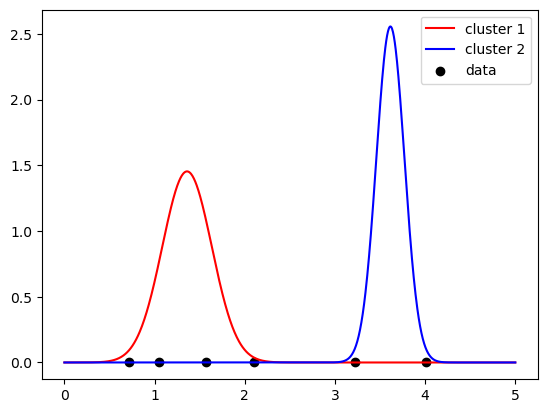

In [272]:
plot_gmm_1d(x, mu1, mu2, sigma1, sigma2)

In [330]:
class HiddenMarkovModel(nn.Module):
    """ 
    class that implements a hidden markov model
    We have an observed sequence of emissions and unknown states.
    We will calculate the probability of the states per time step using the forward algorithm.
    
    Args:
        pi: initial state probabilities
        transition_math: transition matrix
        emission_mat: emission matrix with probabilities of each state emitting each observation
        obs_seq: observed sequence of emissions

    """
    def __init__(self, pi, transition_mat, emission_mat, obs_seq):
        super().__init__()
        self.pi = pi
        self.transition_mat = transition_mat
        self.emission_mat = emission_mat
        self.obs_seq = obs_seq
    
    def forward(self):
        """ 
        Calculate the probability of each state at each time step using the forward algorithm
        """
        # initialize alpha
        alpha = torch.zeros((self.obs_seq.shape[0], self.pi.shape[0]))
        alpha[0] = self.pi * self.emission_mat[:, self.obs_seq[0]]

        # calculate alpha for each time step
        for t in range(1, self.obs_seq.shape[0]):
            alpha[t] = alpha[t-1] @ self.transition_mat * self.emission_mat[:, self.obs_seq[t]]
        return alpha
    
    def calculate_state_prob_from_obs_seq(self, state, time_step):
        """ 
        Calculate the probability of being in a state at a given time step
        from the observeed sequence of emissions
        """
        alpha = self.forward()
        # sum alphas over all states at a given time step
        total_prob = torch.sum(alpha[time_step])
        # calculate the probability of being in a state at a given time step
        prob = alpha[time_step, state] / total_prob
        print(f'p(z = {state} | obs_seq = {self.obs_seq.numpy()}) = {prob:.4f}\n')

        return prob
    
    def print_calculation_each_alpha_(self):
        """ 
        Print the calculation of each alpha and display each state per timestep
        for the obsevered sequence
        """
        print('alpha calculation:\n')
        alpha = self.forward()
        for t in range(self.obs_seq.shape[0]):
            if t == 0:
                for i in range(self.pi.shape[0]):
                    print(f'alpha[{t, i}] = {self.emission_mat[i, self.obs_seq[t]]:.2f} * {self.pi[i]:.2f} = {alpha[t, i]:.5f}')

            else:
                for i in range(self.pi.shape[0]):
                    print(f'alpha[{t, i}] = {self.emission_mat[i, self.obs_seq[t]]:.2f} * ({self.transition_mat[i, 0]:.2f} * {alpha[t-1, 0]:.2f} + {self.transition_mat[i, 1]:.2f} * {alpha[t-1, 1]:.2f}) = {alpha[t, i]:.5f}')
            
            print('\n')
    


In [331]:
# initial state probabilities
pi = torch.tensor([0.1, 0.9])
# transition matrix
transition_mat = torch.tensor([[0.1, 0.9], [0.0, 1.0]])
# emission matrix
emission_mat = torch.tensor([[0.9, 0.1], [0.1, 0.9]])
# observed sequence
obs_seq = torch.tensor([0, 0])

hmm = HiddenMarkovModel(pi, transition_mat, emission_mat, obs_seq)
hmm.print_calculation_each_alpha_()
prob = hmm.calculate_state_prob_from_obs_seq(state=0, time_step=1)


alpha calculation:

alpha[(0, 0)] = 0.90 * 0.10 = 0.09000
alpha[(0, 1)] = 0.10 * 0.90 = 0.09000


alpha[(1, 0)] = 0.90 * (0.10 * 0.09 + 0.90 * 0.09) = 0.00810
alpha[(1, 1)] = 0.10 * (0.00 * 0.09 + 1.00 * 0.09) = 0.01710


p(z = 0 | obs_seq = [0 0]) = 0.3214



In [362]:
pi = torch.tensor([0.1, 0.2, 0.7])
transition_mat = torch.tensor([[0.1, 0.2, 0.7], 
                               [0.0, 0.9, 0.1],
                                 [0.0, 0.0, 1.0]])
emission_mat = torch.tensor([[0.9, 0.1], 
                             [0.1, 0.9], 
                             [0.5, 0.5]])
obs_seq = torch.tensor([0, 0, 1, 1])
hmm = HiddenMarkovModel(pi, transition_mat, emission_mat, obs_seq)
hmm.print_calculation_each_alpha_()
prob = hmm.calculate_state_prob_from_obs_seq(state=2, time_step=3)


alpha calculation:

alpha[(0, 0)] = 0.90 * 0.10 = 0.09000
alpha[(0, 1)] = 0.10 * 0.20 = 0.02000
alpha[(0, 2)] = 0.50 * 0.70 = 0.35000


alpha[(1, 0)] = 0.90 * (0.10 * 0.09 + 0.20 * 0.02) = 0.00810
alpha[(1, 1)] = 0.10 * (0.00 * 0.09 + 0.90 * 0.02) = 0.00360
alpha[(1, 2)] = 0.50 * (0.00 * 0.09 + 0.00 * 0.02) = 0.20750


alpha[(2, 0)] = 0.10 * (0.10 * 0.01 + 0.20 * 0.00) = 0.00008
alpha[(2, 1)] = 0.90 * (0.00 * 0.01 + 0.90 * 0.00) = 0.00437
alpha[(2, 2)] = 0.50 * (0.00 * 0.01 + 0.00 * 0.00) = 0.10676


alpha[(3, 0)] = 0.10 * (0.10 * 0.00 + 0.20 * 0.00) = 0.00000
alpha[(3, 1)] = 0.90 * (0.00 * 0.00 + 0.90 * 0.00) = 0.00356
alpha[(3, 2)] = 0.50 * (0.00 * 0.00 + 0.00 * 0.00) = 0.05363


p(z = 2 | obs_seq = [0 0 1 1]) = 0.9378



In [ ]:
# writes a function that is to be taken gradients of 
x1 = torch.tensor(1.0, requires_grad=True)
w1 = torch.tensor(2.0, requires_grad=True)



In [358]:
np.random.seed(42)
torch.random.seed()
# two arrays of length 4
x1 = np.random.randint(0, 10, 4)
x2 = np.random.randint(0, 10, 4)

print('x1: ', x1)
print('x2: ', x2)
x = torch.tensor([x1, x2], dtype=torch.float32)

print('mu1: ', np.mean(x1))
# get covariance of x
cov = torch.tensor(np.cov(x1, x2), dtype=torch.float32)

cov


x1:  [6 3 7 4]
x2:  [6 9 2 6]
mu1:  5.0


tensor([[ 3.3333, -4.6667],
        [-4.6667,  8.2500]])

In [359]:
print('mu2', np.mean(x2))

mu2 5.75
